## Multi-output Regression with Neural Networks
- Start with base model (MLP using defaults from sklearn)
- Manually experiment with NN architectures & hyperparameter selections
- Use Keras Tuner algorithms then to find better solution
- Use SHAP to assess feature value in final model(s)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn import datasets, linear_model, metrics
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

!pip install -q -U keras-tuner
import tensorflow as tf
import keras_tuner as kt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [8]:
# Load the raw data
#df_all = pd.read_csv('data/220306_slugs_dataset.csv')
df_all = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220306_slugs_dataset.csv')
df_inp = df_all.drop(['loadCase', 'out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1)
df_inp = df_inp.dropna()

# Load the prepared data splits
#X_train = pd.read_csv('data/220421_X_train.csv')
X_train = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_X_train.csv')
X_train.index = X_train.case_ref
X_train.drop(['case_ref'], axis=1, inplace=True)

#y_train = pd.read_csv('data/220421_y_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_y_train.csv')
y_train.index = y_train.case_ref
y_train.drop(['case_ref'], axis=1, inplace=True)

#X_val = pd.read_csv('data/220421_X_val.csv')
X_val = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_X_val.csv')
X_val.index = X_val.case_ref
X_val.drop(['case_ref'], axis=1, inplace=True)

#y_val = pd.read_csv('data/220421_y_val.csv')
y_val = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_y_val.csv')
y_val.index = y_val.case_ref
y_val.drop(['case_ref'], axis=1, inplace=True)

# Prediction features
pred_target = ['out_oopDisp_mm_n2', 'out_oopDisp_mm_n5', 'out_endBend_kNm_n6']

## Base Model using MLP in Sklearn
- Using default model parameters.

In [6]:
clf = MLPRegressor(random_state=1, max_iter=3000).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = clf.predict(X_val.to_numpy())

In [9]:
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

In [11]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_val)
yhat = scaler_m.inverse_transform(y_pred)

for target in range(3):
    y_t = y[:, target]
    yhat_t = yhat[:, target]

    globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
    globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
    globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5) 
    globals()[f'mape_momlp_{target}'] = 100*metrics.mean_absolute_percentage_error(y_t, yhat_t)  
    r2 = metrics.r2_score(y_t, yhat_t)

    print(f'\nTarget {target+1}: Results of sklearn.metrics:')
    print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
    print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
    print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
    print("MAPE:", round(globals()[f'mape_momlp_{target}'], 2))
    print("R-Squared:", round(r2, 2))


Target 1: Results of sklearn.metrics:
MAE: 5.51
MSE: 473.38
RMSE: 21.76
MAPE: 3.04
R-Squared: 0.5

Target 2: Results of sklearn.metrics:
MAE: 9.32
MSE: 1497.47
RMSE: 38.7
MAPE: 5.07
R-Squared: 0.23

Target 3: Results of sklearn.metrics:
MAE: 14.15
MSE: 583.72
RMSE: 24.16
MAPE: 6.6
R-Squared: 0.83


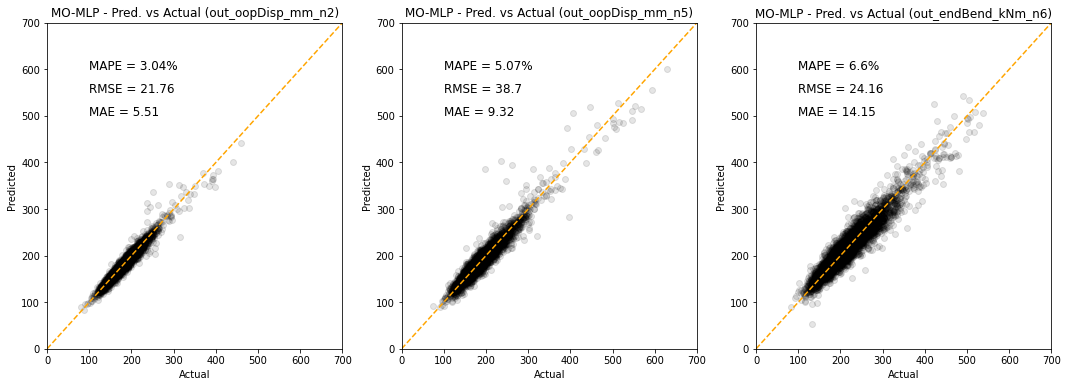

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for p in range(3):
    mae = round(globals()[f'mae_momlp_{p}'], 2)
    rmse = round(globals()[f'rmse_momlp_{p}'], 2)
    mape = round(globals()[f'mape_momlp_{p}'], 2)
    ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
    ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
    ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
    ax[p].text(100, 600, f'MAPE = {round(mape, 2)}%', fontsize = 12)
    ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)    
    ax[p].text(100, 500, f'MAE = {round(mae, 2)}', fontsize = 12)    
    ax[p].set_ylim(0, 700)
    ax[p].set_xlim(0, 700)
plt.show()

## NN Model Experiments

In [14]:
# Manually select architecture & hyperparameters
def gen_model1(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(256, input_dim=n_inputs, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(512, activation='relu'))   
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))    
    model.add(Dense(n_outputs, activation='linear'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model2(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model3(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(100, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model4(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model5(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(60, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model6(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model7(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))
    model.add(Dense(9, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model8(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))
    model.add(Dense(9, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model9(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(9, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model10(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(50, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model11(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.008)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model12(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model13(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model14(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(90, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(30, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model15(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(76, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(38, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model16(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(162, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(106, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [15]:
# Create a function to run a model, calculation & plot metrics
def run_model(model_num, X_for_test, y_for_test, track=False, epos=300, bs=128, verb_out=0):
    # Generate the model
    n_inputs, n_outputs = X_train.to_numpy().shape[1], y_train.to_numpy().shape[1]
    gen_model = globals()[f'gen_model{model_num}']
    nn_model = gen_model(n_inputs, n_outputs)
    if track: model_track.append(model_num)

    # Fit the model
    history = nn_model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=epos, batch_size=bs, validation_data=(X_val.to_numpy(), y_val.to_numpy()), verbose=verb_out).history

    # Plot the training losses
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history['loss'], 'grey', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

    # Make predictions on test data
    y_pred = nn_model.predict(X_for_test.to_numpy())
    y_bas = df_inp[pred_target].to_numpy()
    scaler_m = preprocessing.StandardScaler()
    y_scl = scaler_m.fit_transform(y_bas)

    # Inverse transform (scaling) to review metrics such as MAE
    y = scaler_m.inverse_transform(y_for_test)
    yhat = scaler_m.inverse_transform(y_pred)

    # Collect predictions for return
    y_1, y_2, y_3 = ([], [], [])
    yhat_1, yhat_2, yhat_3 = ([], [], [])

    # Print metrics
    for target in range(3):
        y_t = y[:, target]
        yhat_t = yhat[:, target]
     
        # Append y and yhat for return
        if target == 0:
            y_1.append(y_t)
            yhat_1.append(yhat_t)
        elif target == 1:
            y_2.append(y_t)
            yhat_2.append(yhat_t)
        elif target == 2:
            y_3.append(y_t)
            yhat_3.append(yhat_t)      

        globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
        globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
        globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5) 
        globals()[f'mape_momlp_{target}'] = 100*metrics.mean_absolute_percentage_error(y_t, yhat_t) 
        r2 = metrics.r2_score(y_t, yhat_t)

        print(f'\nTarget {target+1}: Results of sklearn.metrics:')
        print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
        print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
        print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
        print("MAPE:", round(globals()[f'mape_momlp_{target}'], 2))
        print("R-Squared:", round(r2, 2))
        if track: globals()[f'mae_track{target+1}'].append(round(globals()[f'mae_momlp_{target}'], 2))
        if track: globals()[f'rmse_track{target+1}'].append(round(globals()[f'rmse_momlp_{target}'], 2))

    # Plot performance
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    for p in range(3):
        mae = round(globals()[f'mae_momlp_{p}'], 2)
        rmse = round(globals()[f'rmse_momlp_{p}'], 2)
        ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
        ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
        ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
        ax[p].set_title(f'MO-NN - Pred. vs Actual ({pred_target[p]})')
        ax[p].text(100, 600, f'MAE = {round(mae, 2)}', fontsize = 12)
        ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)

    plt.xlim(0, 700)
    plt.ylim(0, 700)
    plt.show()

    # Model predictions dataframe summary
    df = pd.DataFrame(data=list(y_1[0].ravel()), columns=['y_1'])
    df['y_2'] = list(y_2[0].ravel())
    df['y_3'] = list(y_3[0].ravel())
    df['yhat_1'] = list(yhat_1[0].ravel())
    df['yhat_2'] = list(yhat_2[0].ravel())
    df['yhat_3'] = list(yhat_3[0].ravel())

    # Add error calcs including percentage error for later MAPE evaluation
    df = df.assign(
        error_1 = lambda x: x['yhat_1'] - x['y_1'],
        error_2 = lambda x: x['yhat_2'] - x['y_2'],
        error_3 = lambda x: x['yhat_3'] - x['y_3'],
        abs_error_1 = lambda x: x['error_1'].abs(),
        abs_error_2 = lambda x: x['error_2'].abs(),
        abs_error_3 = lambda x: x['error_3'].abs(),
        p_error_1 = lambda x: 100*(x['error_1'].div(x['y_1'])),
        p_error_2 = lambda x: 100*(x['error_2'].div(x['y_2'])),
        p_error_3 = lambda x: 100*(x['error_3'].div(x['y_3']))
    )

    return(df, nn_model)

  0%|          | 0/11 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                960       
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 3)                 123       
                                                                 
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
_________________________________________________________________
None


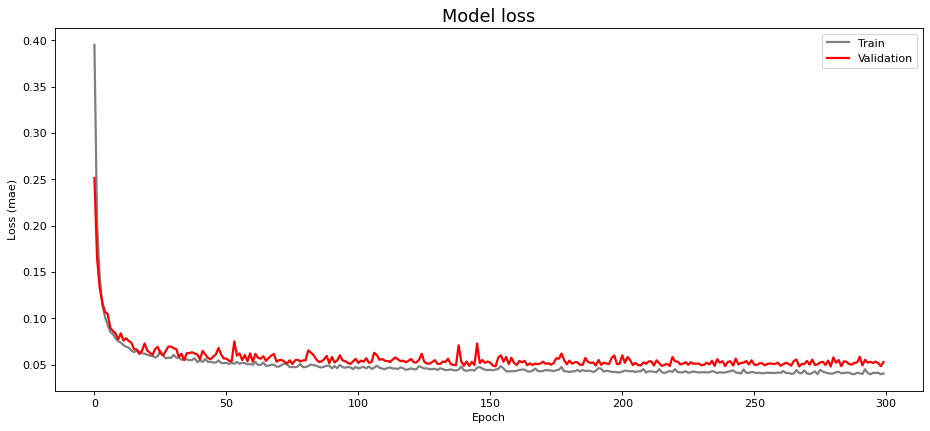


Target 1: Results of sklearn.metrics:
MAE: 4.09
MSE: 37.08
RMSE: 6.09
MAPE: 2.24
R-Squared: 0.96

Target 2: Results of sklearn.metrics:
MAE: 6.73
MSE: 97.39
RMSE: 9.87
MAPE: 3.62
R-Squared: 0.95

Target 3: Results of sklearn.metrics:
MAE: 11.57
MSE: 246.35
RMSE: 15.7
MAPE: 5.33
R-Squared: 0.93


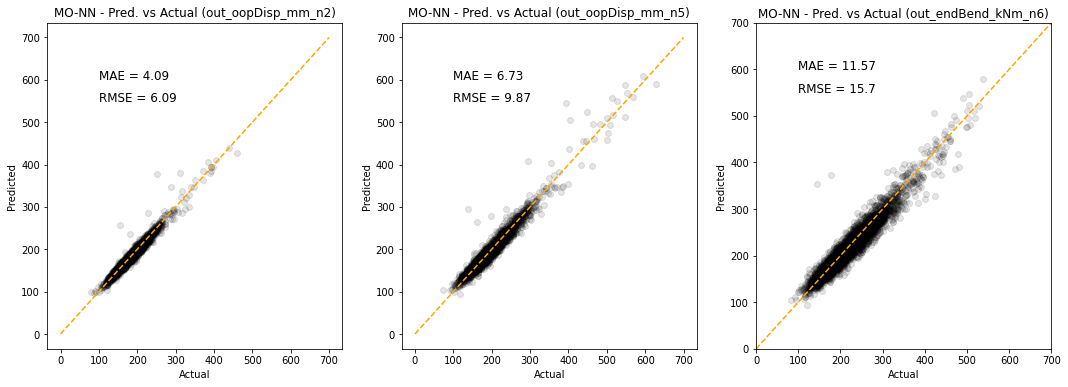

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 80)                960       
                                                                 
 dense_4 (Dense)             (None, 40)                3240      
                                                                 
 dense_5 (Dense)             (None, 9)                 369       
                                                                 
 dense_6 (Dense)             (None, 3)                 30        
                                                                 
Total params: 4,599
Trainable params: 4,599
Non-trainable params: 0
_________________________________________________________________
None


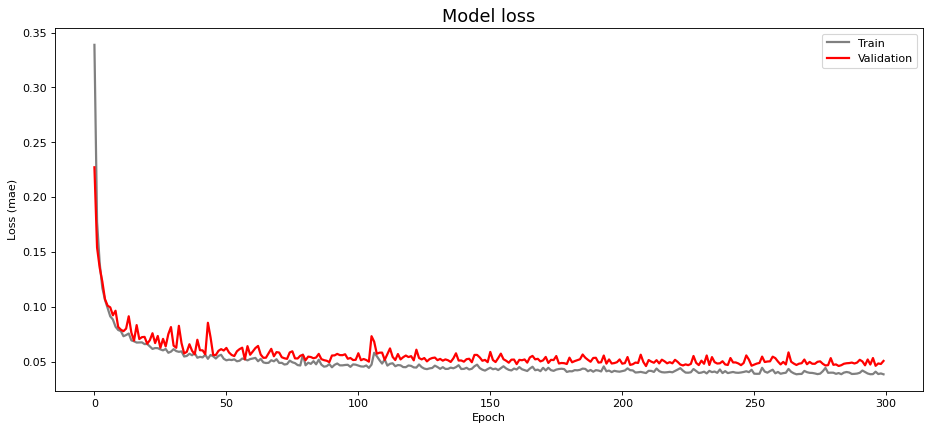


Target 1: Results of sklearn.metrics:
MAE: 4.41
MSE: 37.99
RMSE: 6.16
MAPE: 2.41
R-Squared: 0.96

Target 2: Results of sklearn.metrics:
MAE: 6.83
MSE: 99.91
RMSE: 10.0
MAPE: 3.6
R-Squared: 0.95

Target 3: Results of sklearn.metrics:
MAE: 11.06
MSE: 216.09
RMSE: 14.7
MAPE: 5.06
R-Squared: 0.94


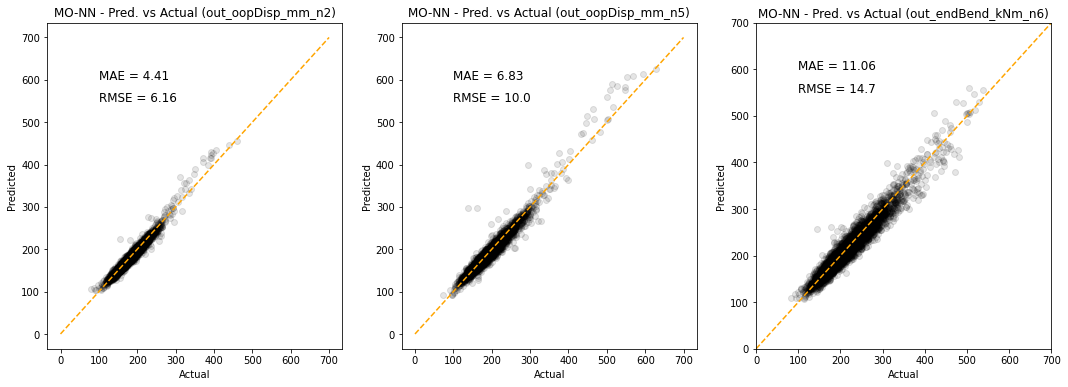

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 80)                960       
                                                                 
 dense_8 (Dense)             (None, 40)                3240      
                                                                 
 dense_9 (Dense)             (None, 9)                 369       
                                                                 
 dense_10 (Dense)            (None, 3)                 30        
                                                                 
Total params: 4,599
Trainable params: 4,599
Non-trainable params: 0
_________________________________________________________________
None


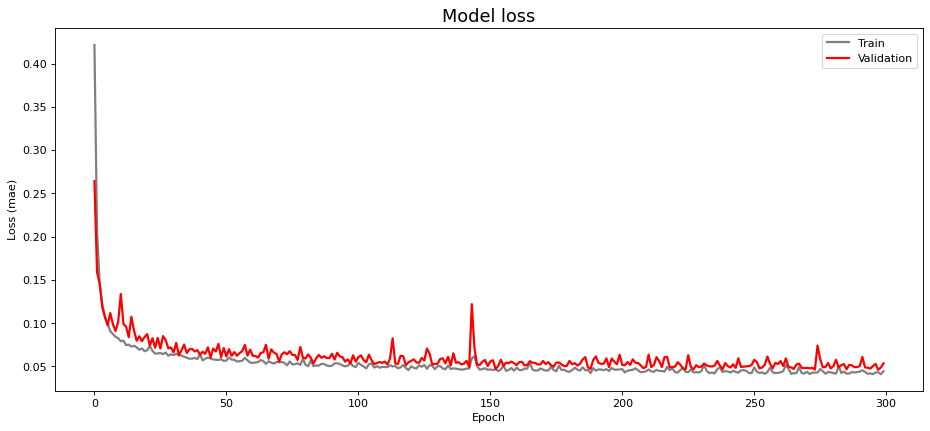


Target 1: Results of sklearn.metrics:
MAE: 4.42
MSE: 40.46
RMSE: 6.36
MAPE: 2.41
R-Squared: 0.96

Target 2: Results of sklearn.metrics:
MAE: 6.95
MSE: 100.27
RMSE: 10.01
MAPE: 3.67
R-Squared: 0.95

Target 3: Results of sklearn.metrics:
MAE: 11.45
MSE: 236.73
RMSE: 15.39
MAPE: 5.26
R-Squared: 0.93


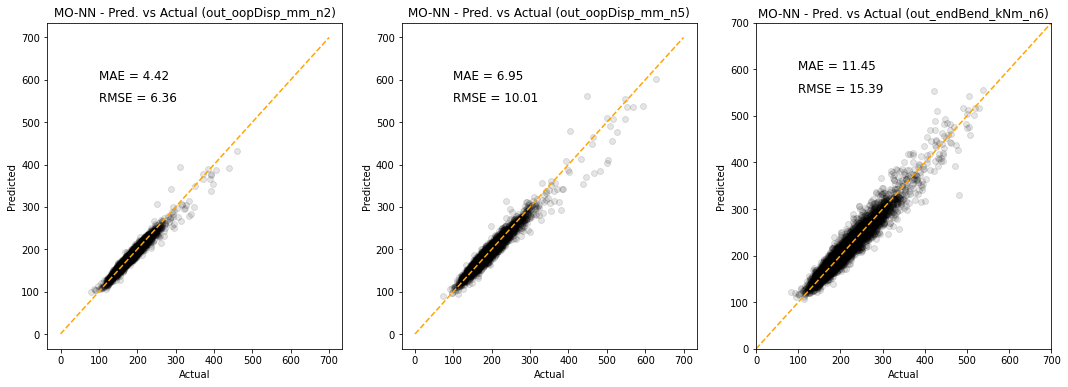

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 80)                960       
                                                                 
 dense_12 (Dense)            (None, 40)                3240      
                                                                 
 dense_13 (Dense)            (None, 9)                 369       
                                                                 
 dense_14 (Dense)            (None, 3)                 30        
                                                                 
Total params: 4,599
Trainable params: 4,599
Non-trainable params: 0
_________________________________________________________________
None


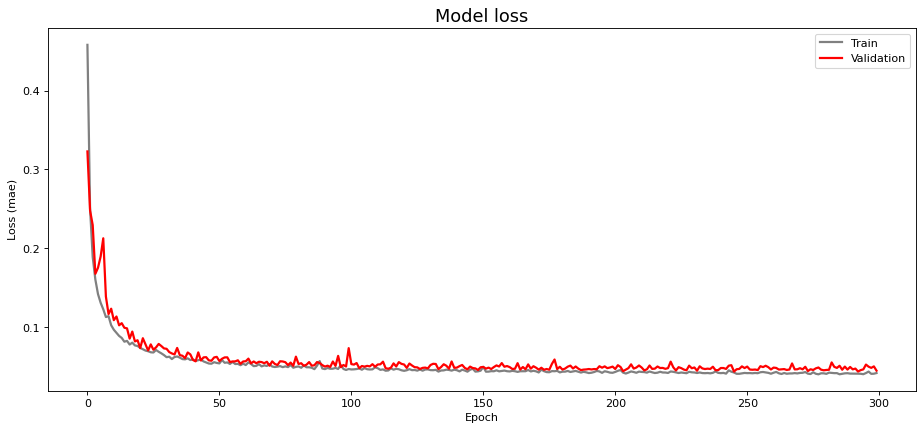


Target 1: Results of sklearn.metrics:
MAE: 4.02
MSE: 28.19
RMSE: 5.31
MAPE: 2.21
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.71
MSE: 78.78
RMSE: 8.88
MAPE: 3.62
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 11.52
MSE: 229.04
RMSE: 15.13
MAPE: 5.28
R-Squared: 0.93


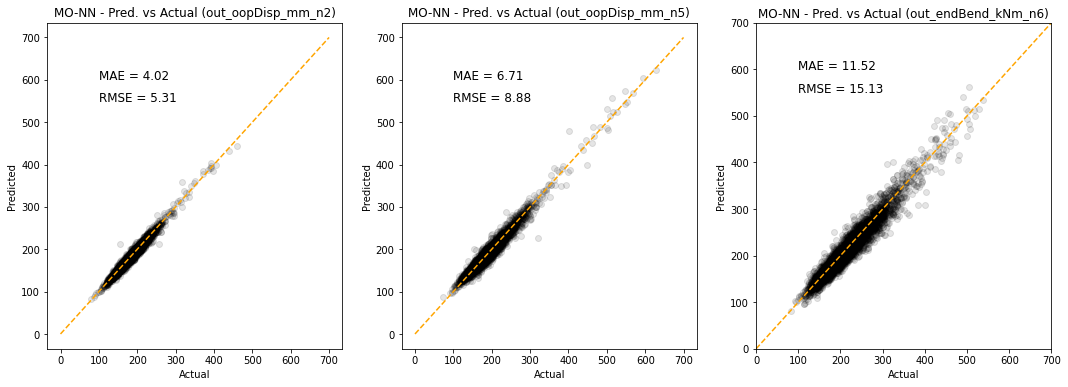

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                600       
                                                                 
 dense_16 (Dense)            (None, 3)                 153       
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________
None


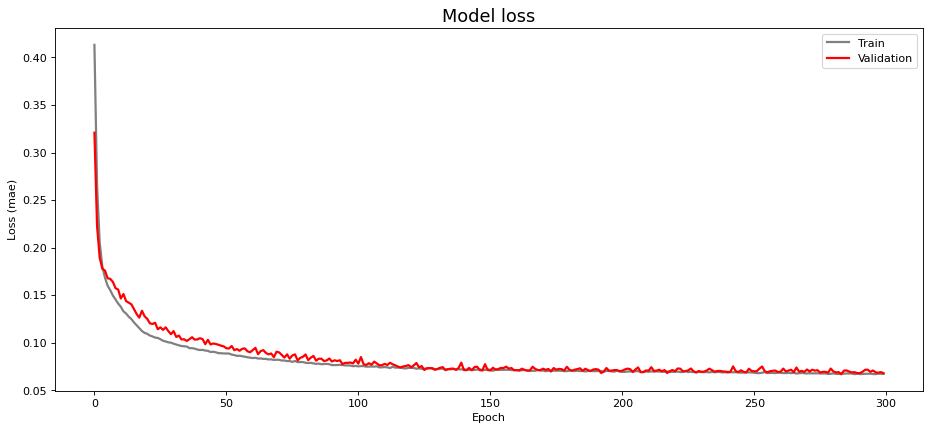


Target 1: Results of sklearn.metrics:
MAE: 4.93
MSE: 45.91
RMSE: 6.78
MAPE: 2.72
R-Squared: 0.95

Target 2: Results of sklearn.metrics:
MAE: 8.11
MSE: 120.75
RMSE: 10.99
MAPE: 4.35
R-Squared: 0.94

Target 3: Results of sklearn.metrics:
MAE: 13.8
MSE: 330.67
RMSE: 18.18
MAPE: 6.36
R-Squared: 0.9


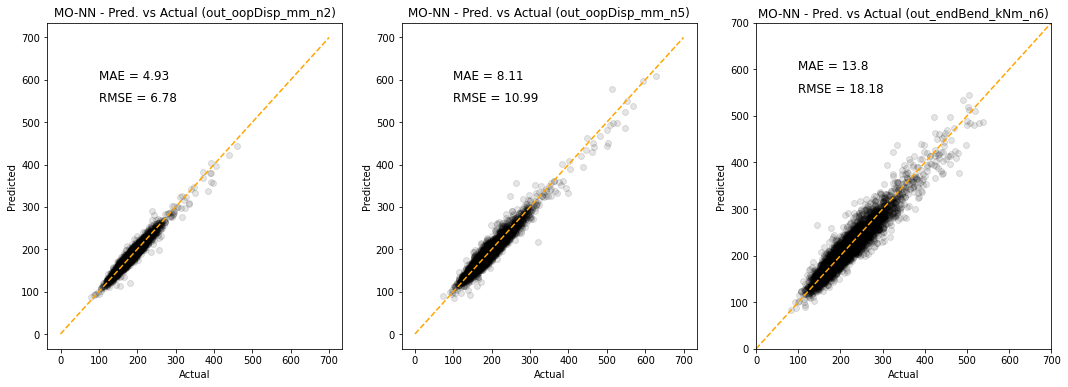

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 80)                960       
                                                                 
 dense_18 (Dense)            (None, 40)                3240      
                                                                 
 dense_19 (Dense)            (None, 3)                 123       
                                                                 
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
_________________________________________________________________
None


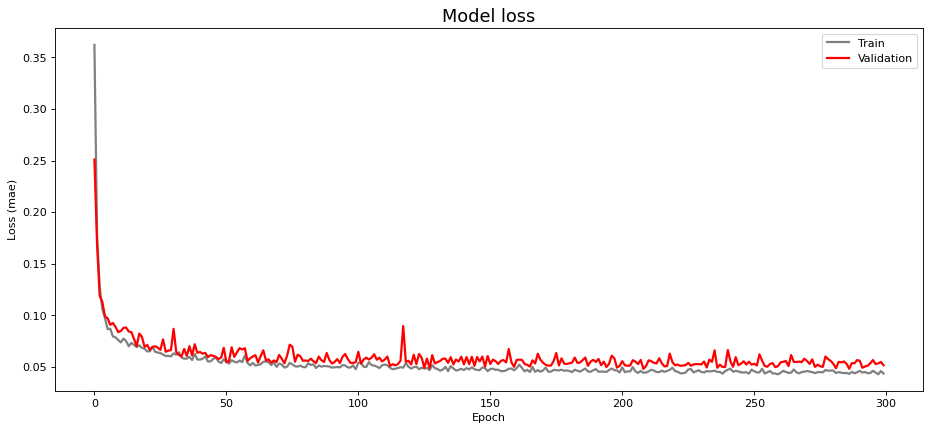


Target 1: Results of sklearn.metrics:
MAE: 4.33
MSE: 36.66
RMSE: 6.05
MAPE: 2.37
R-Squared: 0.96

Target 2: Results of sklearn.metrics:
MAE: 6.69
MSE: 89.81
RMSE: 9.48
MAPE: 3.55
R-Squared: 0.95

Target 3: Results of sklearn.metrics:
MAE: 11.96
MSE: 250.93
RMSE: 15.84
MAPE: 5.5
R-Squared: 0.93


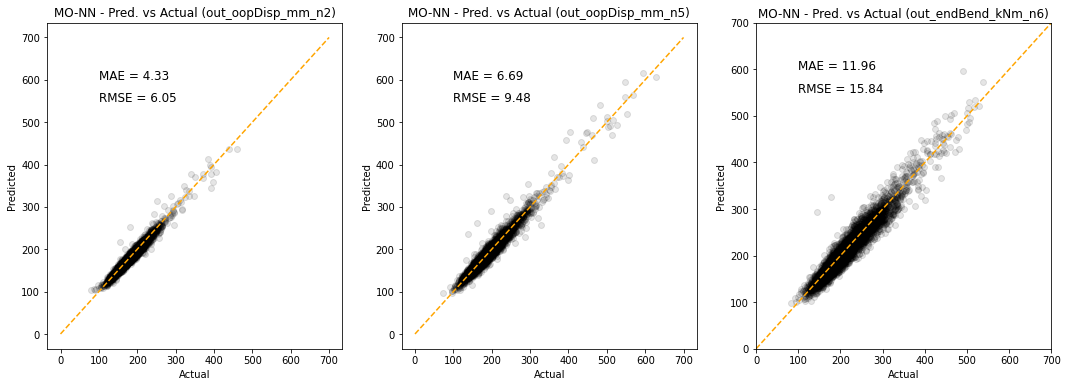

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 80)                960       
                                                                 
 dense_21 (Dense)            (None, 40)                3240      
                                                                 
 dense_22 (Dense)            (None, 3)                 123       
                                                                 
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
_________________________________________________________________
None


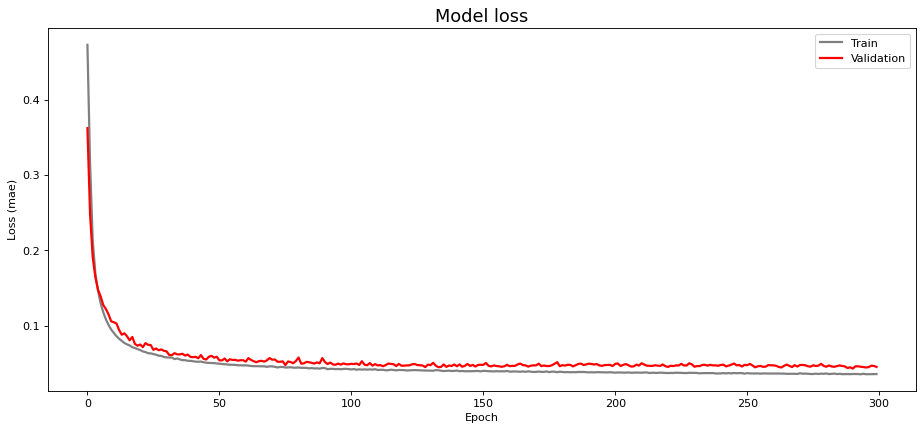


Target 1: Results of sklearn.metrics:
MAE: 4.01
MSE: 30.33
RMSE: 5.51
MAPE: 2.23
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.29
MSE: 78.45
RMSE: 8.86
MAPE: 3.41
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 11.13
MSE: 222.02
RMSE: 14.9
MAPE: 5.16
R-Squared: 0.93


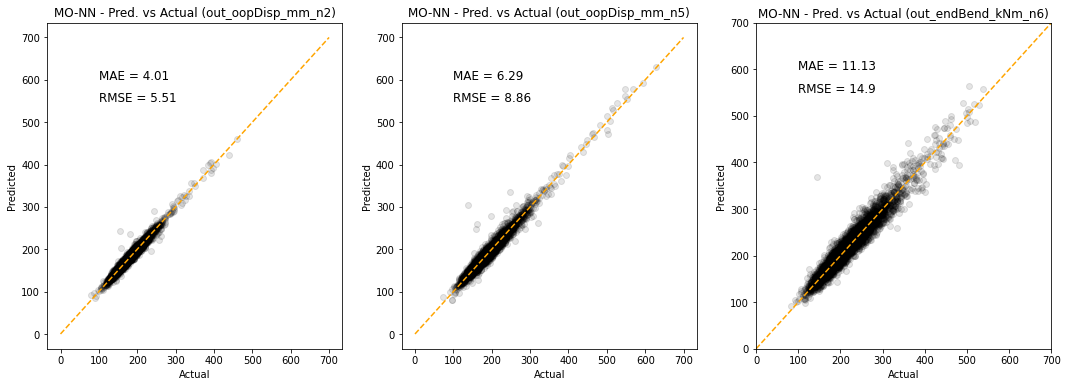

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 80)                960       
                                                                 
 dense_24 (Dense)            (None, 40)                3240      
                                                                 
 dense_25 (Dense)            (None, 3)                 123       
                                                                 
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
_________________________________________________________________
None


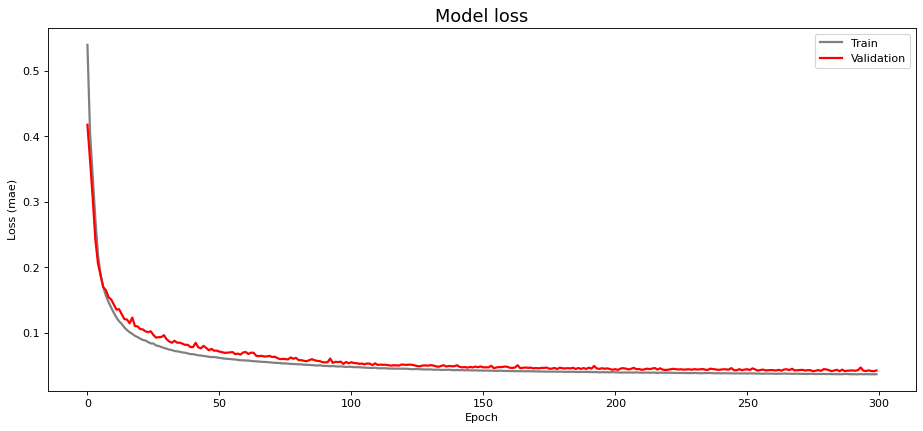


Target 1: Results of sklearn.metrics:
MAE: 3.94
MSE: 27.2
RMSE: 5.22
MAPE: 2.17
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.21
MSE: 73.64
RMSE: 8.58
MAPE: 3.31
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 11.08
MSE: 214.65
RMSE: 14.65
MAPE: 5.08
R-Squared: 0.94


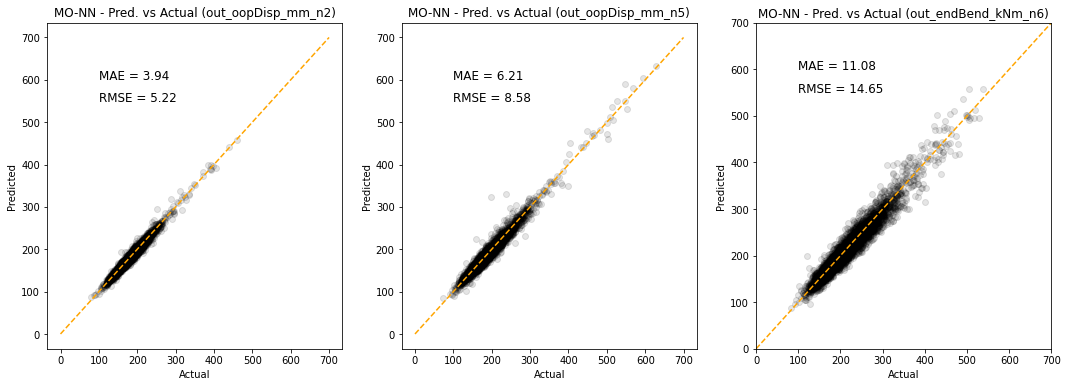

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 90)                1080      
                                                                 
 dense_27 (Dense)            (None, 30)                2730      
                                                                 
 dense_28 (Dense)            (None, 3)                 93        
                                                                 
Total params: 3,903
Trainable params: 3,903
Non-trainable params: 0
_________________________________________________________________
None


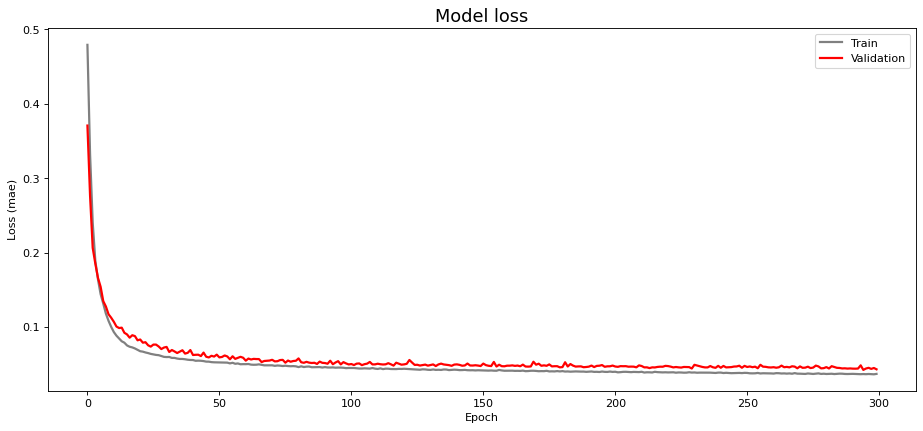


Target 1: Results of sklearn.metrics:
MAE: 4.03
MSE: 30.93
RMSE: 5.56
MAPE: 2.22
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.35
MSE: 78.07
RMSE: 8.84
MAPE: 3.4
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 10.89
MSE: 203.98
RMSE: 14.28
MAPE: 5.01
R-Squared: 0.94


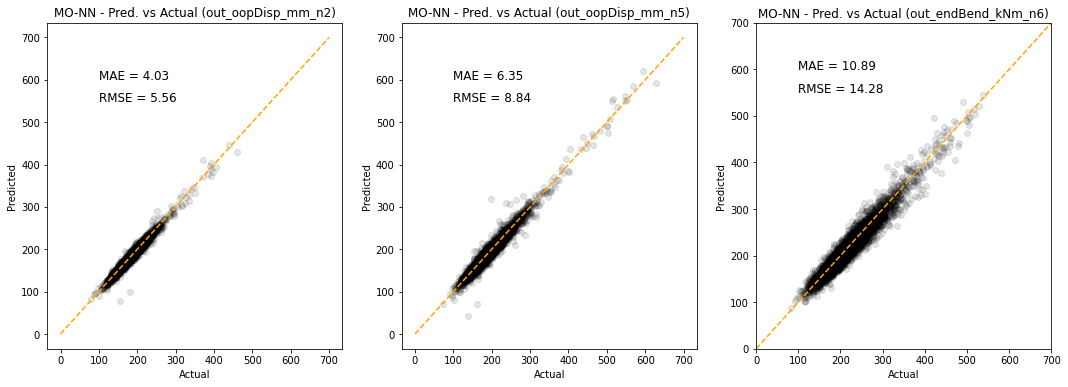

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 76)                912       
                                                                 
 dense_30 (Dense)            (None, 38)                2926      
                                                                 
 dense_31 (Dense)            (None, 3)                 117       
                                                                 
Total params: 3,955
Trainable params: 3,955
Non-trainable params: 0
_________________________________________________________________
None


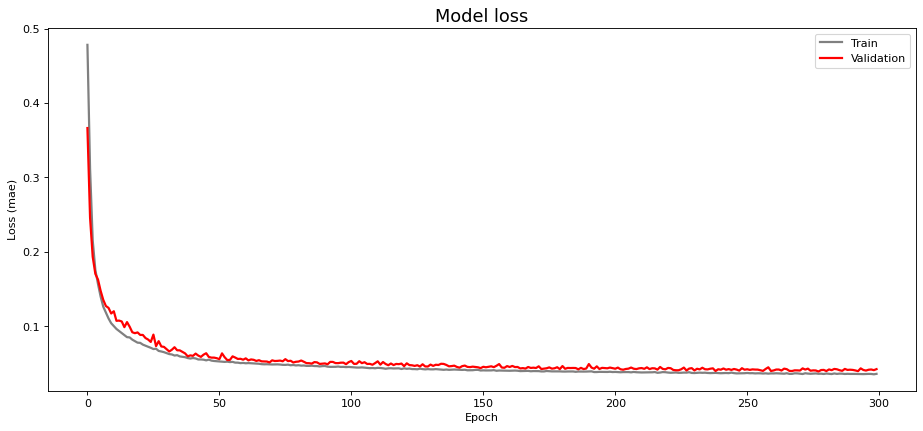


Target 1: Results of sklearn.metrics:
MAE: 4.29
MSE: 30.53
RMSE: 5.53
MAPE: 2.4
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.58
MSE: 78.22
RMSE: 8.84
MAPE: 3.58
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 10.59
MSE: 194.33
RMSE: 13.94
MAPE: 4.92
R-Squared: 0.94


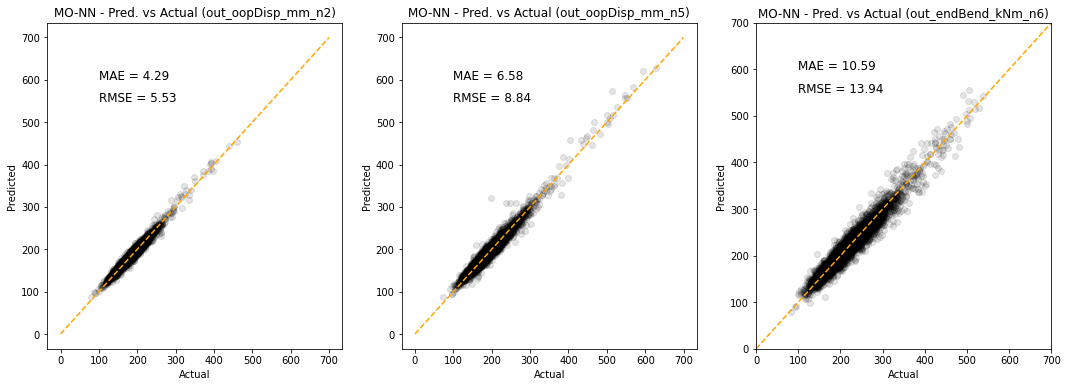

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 162)               1944      
                                                                 
 dense_33 (Dense)            (None, 106)               17278     
                                                                 
 dense_34 (Dense)            (None, 3)                 321       
                                                                 
Total params: 19,543
Trainable params: 19,543
Non-trainable params: 0
_________________________________________________________________
None


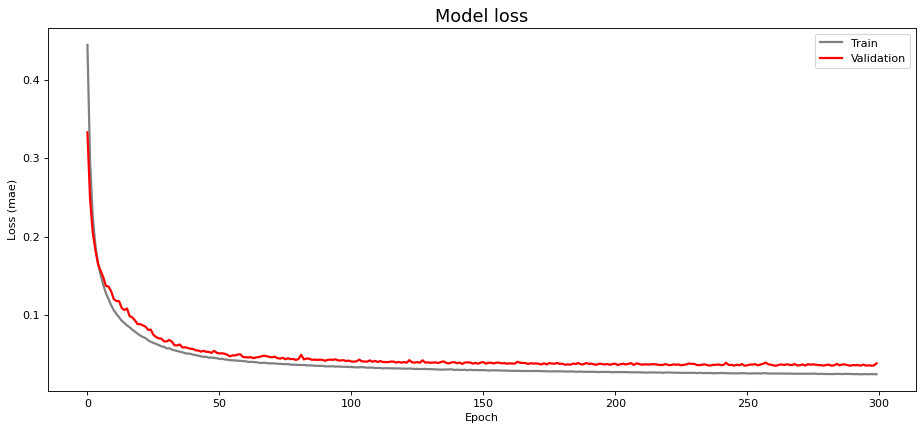


Target 1: Results of sklearn.metrics:
MAE: 3.83
MSE: 25.2
RMSE: 5.02
MAPE: 2.12
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.11
MSE: 66.73
RMSE: 8.17
MAPE: 3.29
R-Squared: 0.97

Target 3: Results of sklearn.metrics:
MAE: 10.55
MSE: 195.04
RMSE: 13.97
MAPE: 4.89
R-Squared: 0.94


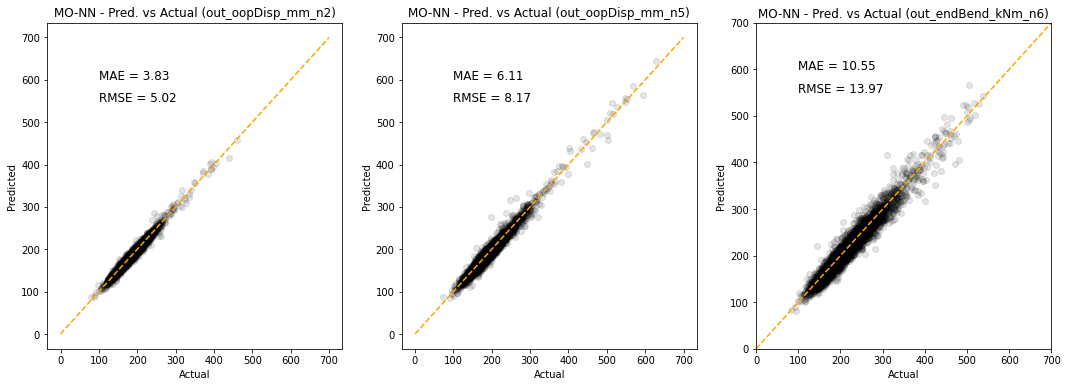

In [16]:
# Loop through and fit each model and collect performance results.
model_track = []
mae_track1, mae_track2, mae_track3 = ([], [], [])
rmse_track1, rmse_track2, rmse_track3 = ([], [], [])
for m_num  in tqdm(range(5, 16, 1)):
    model_num = m_num + 1
    run_model(model_num, X_val, y_val, track=True, verb_out=0)

In [ ]:
# Model tracking dataframe summary
experiments = pd.DataFrame(data=model_track, columns=['model_ref'])
experiments['mae1'] = mae_track1
experiments['mae2'] = mae_track2
experiments['mae3'] = mae_track3
experiments['rmse1'] = rmse_track1
experiments['rmse2'] = rmse_track2
experiments['rmse3'] = rmse_track3
experiments

,model_ref,mae1,mae2,mae3,rmse1,rmse2,rmse3
0,6,4.20,6.60,11.05,5.78,9.24,14.57
1,7,4.29,6.83,11.21,5.88,9.56,15.09
2,8,4.60,7.03,11.42,6.74,10.30,15.29
3,9,4.11,6.66,11.46,5.64,9.23,15.19
4,10,4.89,8.23,14.07,6.65,11.13,18.56
5,11,4.46,7.03,11.36,6.20,9.94,15.16
6,12,4.11,6.60,11.06,5.63,9.00,14.56
7,13,3.94,6.19,11.07,5.33,8.46,14.74
8,14,3.98,6.28,11.31,5.43,8.63,15.04
9,15,3.97,6.26,10.98,5.52,8.69,14.75


## Hyperparameter Tuning using Keras Tuner

In [ ]:
# Notes:
# ======
# 1. Initial runs included boolean for dropout - dropout was never picked as part if the best configuration
# 2. Experiments run with 1 and 2 hidden layers
def hp_model_builder(hp):
    n_inputs, n_outputs = X_train.to_numpy().shape[1], y_train.to_numpy().shape[1]
    model = Sequential()
    
    # Tune the number of units in the two Dense layers
    #hp_units1 = hp.Int('units_h1', min_value=24, max_value=1024, step=4)
    #hp_units1 = hp.Int('units_h1', min_value=30, max_value=240, step=4)
    #hp_units2 = hp.Int('units_h2', min_value=10, max_value=160, step=4)

    hp_units1 = hp.Int('units_h1', min_value=24, max_value=1024, step=4)
    hp_units2 = hp.Int('units_h2', min_value=24, max_value=1024, step=4)
    hp_units3 = hp.Int('units_h3', min_value=24, max_value=1024, step=4)

    # Tune whether to use dropout on visible input layer.
    #if hp.Boolean("dropout_visible"):
    #    model.add(Dropout(0.2, input_shape=(n_inputs,)))
    #    model.add(Dense(units=hp_units1, kernel_initializer='he_uniform', activation='tanh'))
    #else:
    
    model.add(Dense(units=hp_units1, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(units=hp_units2, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(units=hp_units3, kernel_initializer='he_uniform', activation='tanh'))   
    # Tune whether to use dropout on hidden-hidden and hidden-output layer.
    #if hp.Boolean("dropout_hidden"): model.add(Dropout(0.2))
    #model.add(Dense(units=hp_units2, kernel_initializer='he_uniform', activation='tanh')) 
    #if hp.Boolean("dropout_hidden"): model.add(Dropout(0.2))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from list
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.05, 0.001, 0.002, 0.005, 0.0001])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

In [ ]:
class batch_hyper_model(kt.HyperModel):
    def build(self, hp):
        n_inputs, n_outputs = X_train.to_numpy().shape[1], y_train.to_numpy().shape[1]
        model = Sequential()
        hp_units1 = hp.Int('units_h1', min_value=120, max_value=132, step=3)
        hp_units2 = hp.Int('units_h2', min_value=140, max_value=152, step=3)
        model.add(Dense(hp_units1, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
        model.add(Dense(hp_units1, kernel_initializer='he_uniform', activation='tanh'))  
        model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            #batch_size=hp.Int("batch_size", min_value=24, max_value=524, step=4),
            batch_size=hp.Choice("batch_size", values=[1, len(train), 8, 16, 32, 64, 96, 128]),
            **kwargs,
        )

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

### a) Hyperband Optimizer

In [ ]:
tuner = kt.Hyperband(
    batch_hyper_model(),
    objective='val_loss',
    max_epochs=300,
    factor=3,
    # Remove overwrite and use dirs to save each runs to file.
    overwrite=True
    #directory='work_dir',
    #project_name='kt_tuner_proj'
    )

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [17]:
tuner.search(X_train.to_numpy(), y_train.to_numpy(), epochs=300, validation_data=(X_val.to_numpy(), y_val.to_numpy()), callbacks=[stop_early])

In [20]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

LR = {best_hps.get('learning_rate')}.
N1 = {best_hps.get('units_h1')}
print(f"""
N2 = {best_hps.get('units_h2')}
BS = {best_hps.get('batch_size')}
""")

### b) Bayesian Optimizer

In [ ]:
bo_tuner = kt.BayesianOptimization(
    hp_model_builder,
    objective='val_loss',
    max_trials=150,
    seed=0,
    overwrite=True
    )
bo_tuner.search(X_train.to_numpy(), y_train.to_numpy(), epochs=150, validation_split=0.20, callbacks=[stop_early])

Trial 115 Complete [00h 09m 58s]
val_loss: 0.06538859754800797

Best val_loss So Far: 0.05693339183926582
Total elapsed time: 13h 12m 38s

Search: Running Trial #116

Value             |Best Value So Far |Hyperparameter
134               |126               |units_h1
146               |146               |units_h2
False             |False             |dropout_hidden
0.0001            |0.0001            |learning_rate

Epoch 1/150
1000/1000 [==============================] - 14s 9ms/step - loss: 0.5288 - val_loss: 0.4630
Epoch 2/150
1000/1000 [==============================] - 79s 78ms/step - loss: 0.4237 - val_loss: 0.4173
Epoch 3/150
1000/1000 [==============================] - 56s 55ms/step - loss: 0.3929 - val_loss: 0.3900
Epoch 4/150
1000/1000 [==============================] - 8s 7ms/step - loss: 0.3670 - val_loss: 0.3655
Epoch 5/150
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3419 - val_loss: 0.3376
Epoch 6/150
1000/1000 [==============================] - 3s 

In [ ]:
# Get the optimal hyperparameters
best_bo_hps=bo_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_bo_hps.get('units_h1')} and for the 2nd layer is {best_hps.get('units_h2')}. The the optimal learning rate for the optimizer
is {best_bo_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 238 and for the 2nd layer is 154. The the optimal learning rate for the optimizer
is 0.0001.



### Run Best Models from Tuning & Review Performance

In [21]:
def gen_model101(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(86, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(154, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model102(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(238, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(154, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model103(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(74, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(130, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model104(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(126, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(146, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model105(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(692, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model106(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(476, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))
    model.add(Dense(188, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(356, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

# James Nagle's 4 hidden layers
def gen_model107(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(256, input_dim=n_inputs, activation='relu'))    
    model.add(Dense(512, activation='relu'))        
    model.add(Dense(256, activation='relu'))    
    model.add(Dense(128, activation='relu'))    
    model.add(Dense(64, activation='relu'))    
    model.add(Dense(n_outputs, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    print(model.summary())
    return model

# Following batch size optimizer run
def gen_model108(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(192, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(60, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 74)                888       
                                                                 
 dense_36 (Dense)            (None, 130)               9750      
                                                                 
 dense_37 (Dense)            (None, 3)                 393       
                                                                 
Total params: 11,031
Trainable params: 11,031
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
317/317 [==============================] - 2s 4ms/step - loss: 0.4716 - val_loss: 0.3777
Epoch 2/300
317/317 [==============================] - 1s 3ms/step - loss: 0.3506 - val_loss: 0.3076
Epoch 3/300
317/317 [==============================] - 1s 4ms/step - loss: 0.2701 - val_loss: 0.2357
Epoch

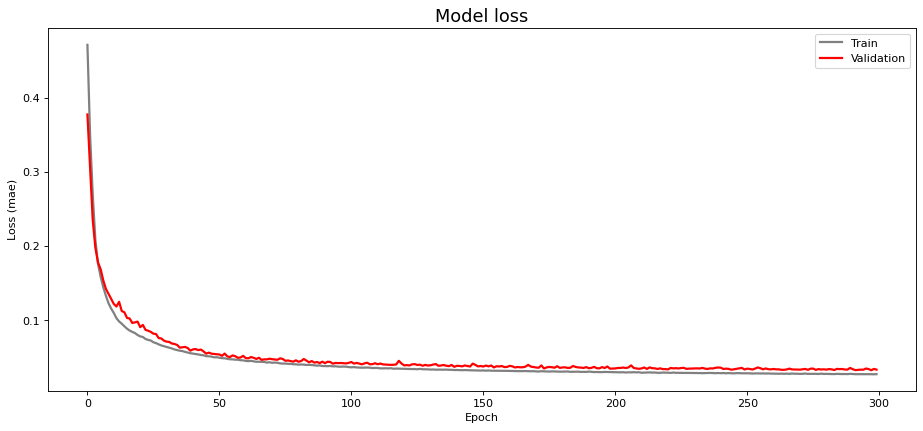


Target 1: Results of sklearn.metrics:
MAE: 3.51
MSE: 21.38
RMSE: 4.62
MAPE: 1.94
R-Squared: 0.98

Target 2: Results of sklearn.metrics:
MAE: 5.89
MSE: 61.15
RMSE: 7.82
MAPE: 3.17
R-Squared: 0.97

Target 3: Results of sklearn.metrics:
MAE: 9.83
MSE: 165.43
RMSE: 12.86
MAPE: 4.61
R-Squared: 0.95


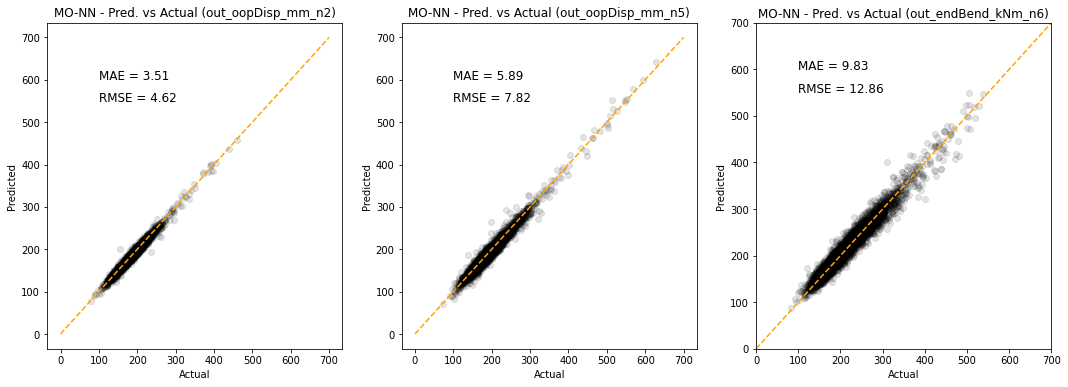

In [22]:
# Model suggested from Hyperband optimizer
out_103, model_103 = run_model(103, X_val, y_val, verb_out=1)

In [24]:
# Create a visualisation of percentage error for all points & include MAPE, MAE & RMSE as text
def gen_band_output(df):
    """
    MAPE is commonly used to measure forecasting errors, but it can be deceiving when values reach
    numbers close to zero. WAPE is a measure that counters this by weighting the error over totals. 
    """
    for param in range(1, 4, 1):
        globals()[f'mape_{param}'] = round(df[f'p_error_{param}'].abs().mean(), 2)
        globals()[f'wape_{param}'] = round(100*(df[f'error_{param}'].abs().sum() / df[f'y_{param}'].abs().sum()), 2)
        globals()[f'mae_{param}'] = metrics.mean_absolute_error(df[f'y_{param}'], df[f'yhat_{param}'])
        globals()[f'mse_{param}']  = metrics.mean_squared_error(df[f'y_{param}'], df[f'yhat_{param}'])
        globals()[f'rmse_{param}'] = np.sqrt(globals()[f'mse_{param}']) # or mse**(0.5) 

    # Plot percentage error (PE) and further evaluate performance
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    for p in range(3):
        mape = globals()[f'mape_{p+1}']
        mae = globals()[f'mae_{p+1}']
        rmse = globals()[f'rmse_{p+1}']
        df_plot = df.sort_values([f'y_{p+1}'], ascending=True)
        df_plot_below = df_plot.loc[(df[f'p_error_{p+1}'].abs() <= 10), :]
        df_plot_above = df_plot.loc[(df[f'p_error_{p+1}'].abs() > 10), :]
        ax[p].scatter(df_plot_below[f'y_{p+1}'], df_plot_below[f'p_error_{p+1}'], color = 'black', zorder = 2, alpha=0.2)
        ax[p].scatter(df_plot_above[f'y_{p+1}'], df_plot_above[f'p_error_{p+1}'], color = 'grey', zorder = 3, alpha=0.2)
        ax[p].text(570, 16, '+10% PE', fontsize = 10, color = 'darkorange')
        ax[p].plot([0, 700], [10, 10], '--', color = 'orange', zorder = 4)
        ax[p].text(570, -20, '-10% PE', fontsize = 10, color = 'darkorange')
        ax[p].plot([0, 700], [-10, -10], '--', color = 'orange', zorder = 4)
        ax[p].add_patch(patches.Rectangle((0, -10), 700, 20, color ='orange', zorder = 1, alpha=0.1))
        ax[p].set(ylabel = 'Percentage Error (PE)', xlabel = 'Actual')
        ax[p].text(400, 80, f'MAPE = {round(mape, 2)}%', fontsize = 12)
        ax[p].text(400, 67, f'RMSE = {round(rmse, 2)}', fontsize = 12)
        ax[p].text(400, 54, f'MAE = {round(mae, 2)}', fontsize = 12)
        ax[p].set_ylim(-100, 100)
        ax[p].set_xlim(0, 700)
        ax[p].set_title(f'MO-NN: PE ({pred_target[p]})') 
    plt.show()

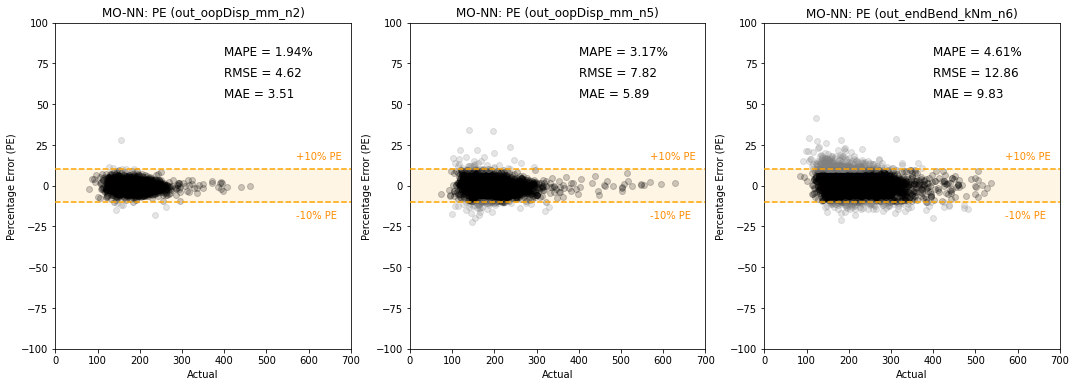

In [25]:
gen_band_output(out_103)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               2304      
                                                                 
 dense_1 (Dense)             (None, 60)                11580     
                                                                 
 dense_2 (Dense)             (None, 3)                 183       
                                                                 
Total params: 14,067
Trainable params: 14,067
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
1687/1687 [==============================] - 7s 4ms/step - loss: 0.3703 - val_loss: 0.2501
Epoch 2/300
1687/1687 [==============================] - 6s 3ms/step - loss: 0.2082 - val_loss: 0.1767
Epoch 3/300
1687/1687 [==============================] - 6s 4ms/step - loss: 0.1577 - val_loss: 0.1474
Ep

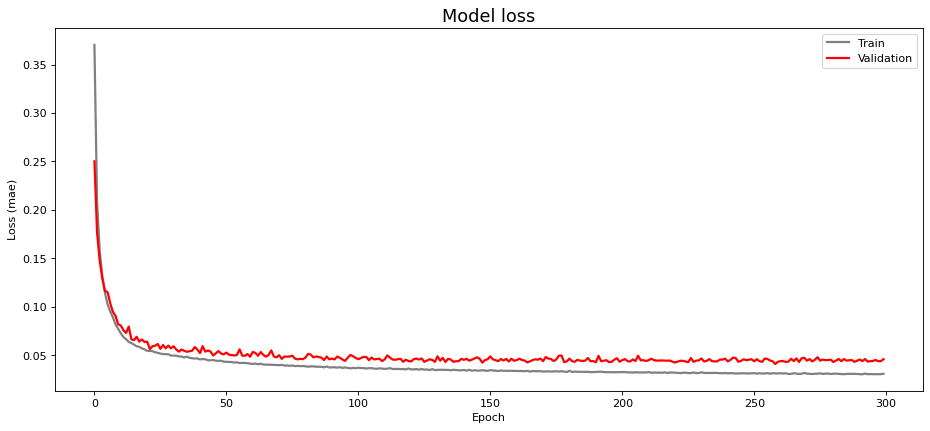


Target 1: Results of sklearn.metrics:
MAE: 4.07
MSE: 31.69
RMSE: 5.63
MAPE: 2.24
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.53
MSE: 92.79
RMSE: 9.63
MAPE: 3.48
R-Squared: 0.95

Target 3: Results of sklearn.metrics:
MAE: 10.72
MSE: 202.99
RMSE: 14.25
MAPE: 4.94
R-Squared: 0.94


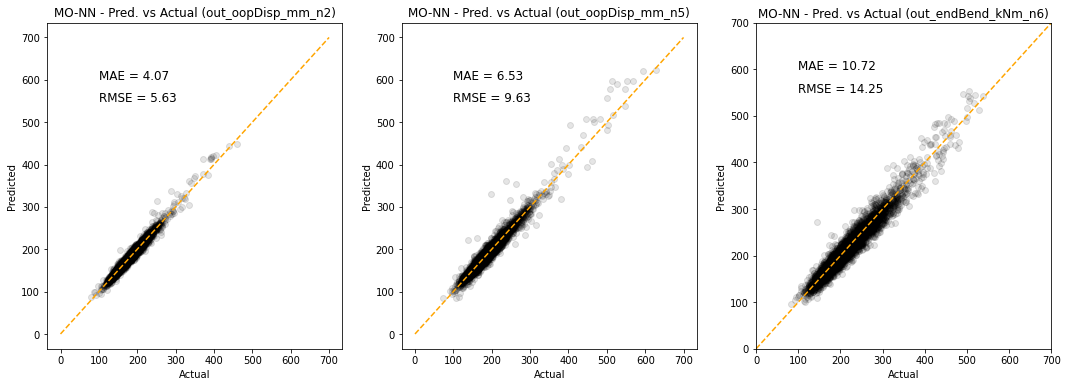

In [ ]:
# Model suggested from Hyperband optimizer
out_108, model_108 = run_model(108, X_val, y_val, bs=24, verb_out=1)

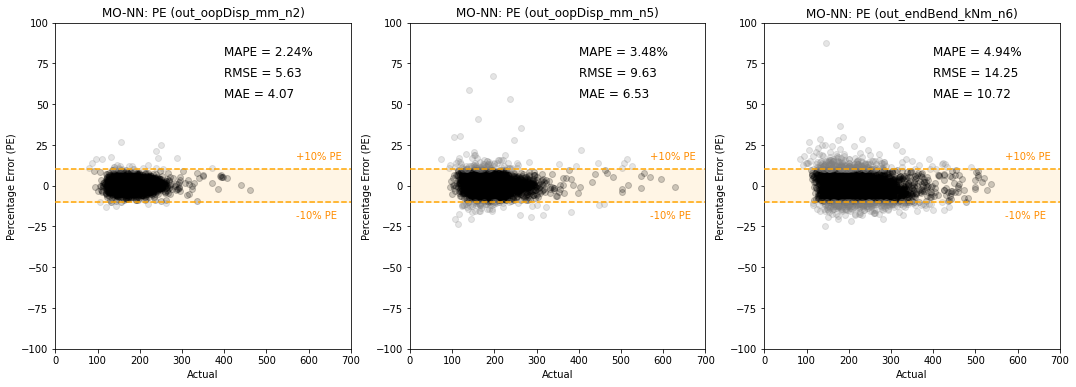

In [ ]:
gen_band_output(out_108)

## Feature Attributions: SHAP (SHapley Additive exPlanations)
Use SHAP to get an understanding of features that are driving the model.

In [ ]:
!pip install shap
import shap
# print the JS visualization code to the notebook
shap.initjs()

     |████████████████████████████████| 564 kB 5.0 MB/s 


In [ ]:
explainer = shap.KernelExplainer(model = model_103.predict, data = X_train.head(200), link = "identity")

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
# Start with first 200 training examples
shap_values = explainer.shap_values(X = X_train.iloc[0:200,:], nsamples = 100)

  0%|          | 0/200 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: 

Parameter: out_oopDisp_mm_n2



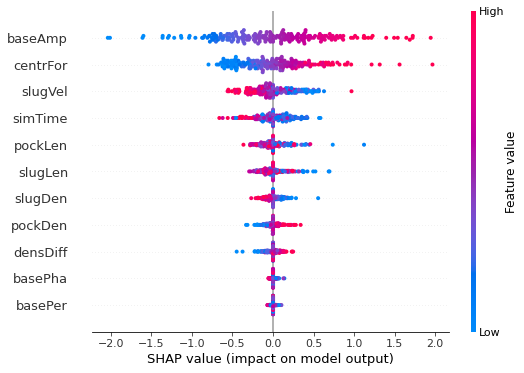



Parameter: out_oopDisp_mm_n5



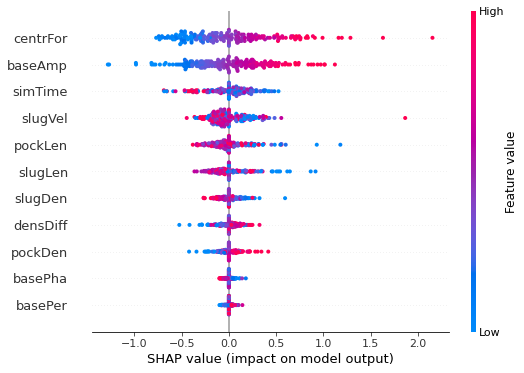



Parameter: out_endBend_kNm_n6



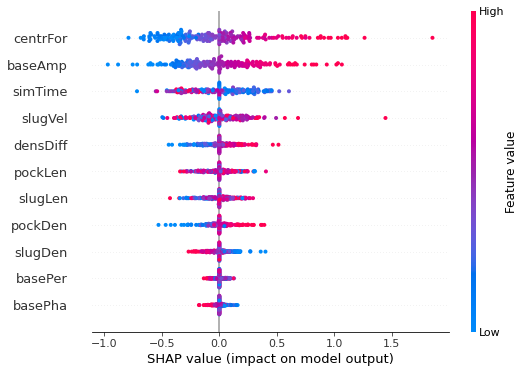

In [ ]:
# Create a visualisation of parameters that are driving model predictions
# Red will be increasing output
# Blue will be decreasing output
shap.initjs()
# Reminder of target parameters
# pred_target = ['out_oopDisp_mm_n2', 'out_oopDisp_mm_n5', 'out_endBend_kNm_n6']

# Loop through and plot for each target parameter the SHAP value plot
for shap_param in range(3):
    select_param = pred_target[shap_param]
    print(f'Parameter: {select_param}\n')
    shap.summary_plot(shap_values = shap_values[shap_param], features = X_train.iloc[0:200,:]) 
    print(f'\n')

The above makes sense and is line expectation / domain concepts. Centrifugal force is expected to drive out-of-plane response. Base amplitude period and phase angle would not be expected to drive response.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 238)               2856      
                                                                 
 dense_16 (Dense)            (None, 154)               36806     
                                                                 
 dense_17 (Dense)            (None, 3)                 465       
                                                                 
Total params: 40,127
Trainable params: 40,127
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
317/317 [==============================] - 2s 4ms/step - loss: 0.4376 - val_loss: 0.3254
Epoch 2/300
317/317 [==============================] - 1s 3ms/step - loss: 0.2746 - val_loss: 0.2463
Epoch 3/300
317/317 [==============================] - 1s 3ms/step - loss: 0.2041 - val_loss: 0.1936
Epoch 

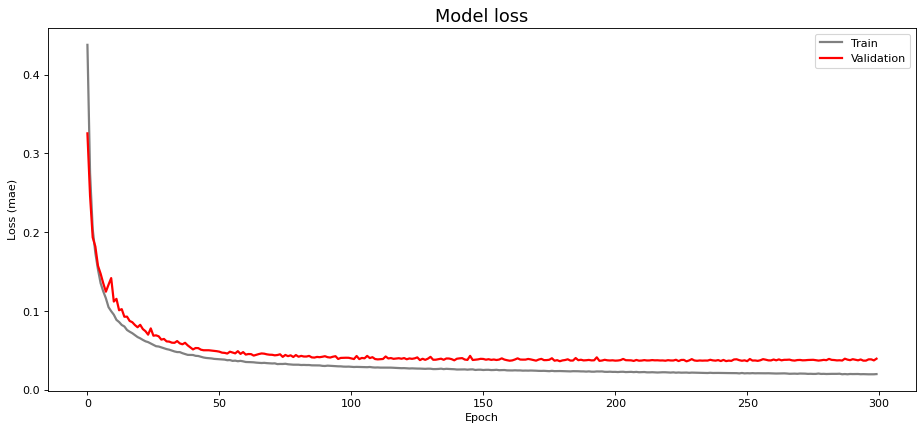


Target 1: Results of sklearn.metrics:
MAE: 4.07
MSE: 28.3
RMSE: 5.32
MAPE: 2.26
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.06
MSE: 69.34
RMSE: 8.33
MAPE: 3.27
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 10.53
MSE: 192.5
RMSE: 13.87
MAPE: 4.91
R-Squared: 0.94


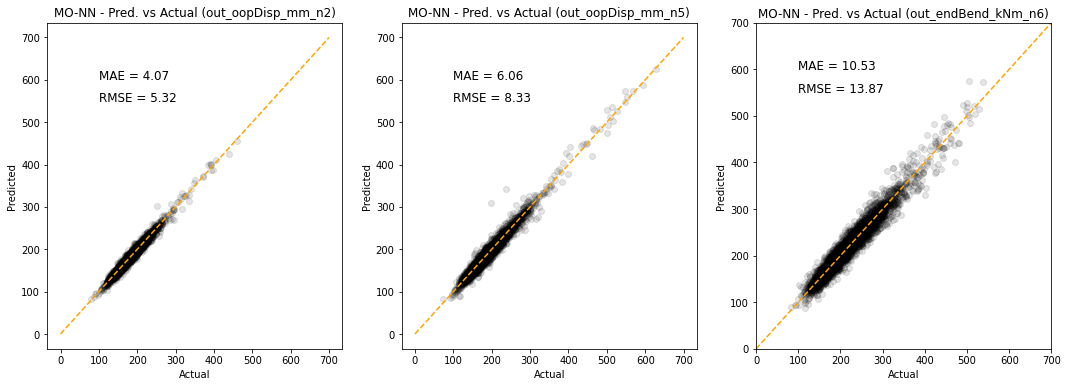

(         y_1     y_2     y_3      yhat_1      yhat_2      yhat_3   error_1  \
 0     170.15  160.72  155.94  171.448929  167.425323  168.559769  1.298929   
 1     143.65  141.39  148.19  140.840500  139.018250  129.379974 -2.809500   
 2     208.40  211.32  245.60  206.635483  203.792465  239.376373 -1.764517   
 3     213.04  205.64  217.49  213.925140  200.899124  227.424500  0.885140   
 4     191.69  188.46  253.10  190.863846  193.038086  260.828064 -0.826154   
 ...      ...     ...     ...         ...         ...         ...       ...   
 4493  192.92  166.54  170.86  183.074310  157.817490  179.270004 -9.845690   
 4494  150.16  180.48  206.46  152.640442  174.853973  200.761795  2.480442   
 4495  294.64  355.22  333.10  291.565308  350.124481  345.453552 -3.074692   
 4496  175.94  222.13  183.99  175.636887  211.297684  190.324966 -0.303113   
 4497  175.14  186.28  181.09  175.864609  196.075150  177.559311  0.724609   
 
         error_2    error_3  abs_error_1  abs_erro

In [ ]:
# Model suggestin from Bayesian optimizer
out_102, model_102 = run_model(102, X_val, y_val, verb_out=1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 126)               1512      
                                                                 
 dense_39 (Dense)            (None, 146)               18542     
                                                                 
 dense_40 (Dense)            (None, 3)                 441       
                                                                 
Total params: 20,495
Trainable params: 20,495
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
317/317 [==============================] - 3s 7ms/step - loss: 0.4416 - val_loss: 0.3529
Epoch 2/300
317/317 [==============================] - 2s 6ms/step - loss: 0.2961 - val_loss: 0.2434
Epoch 3/300
317/317 [==============================] - 2s 5ms/step - loss: 0.2246 - val_loss: 0.2088
Epoch

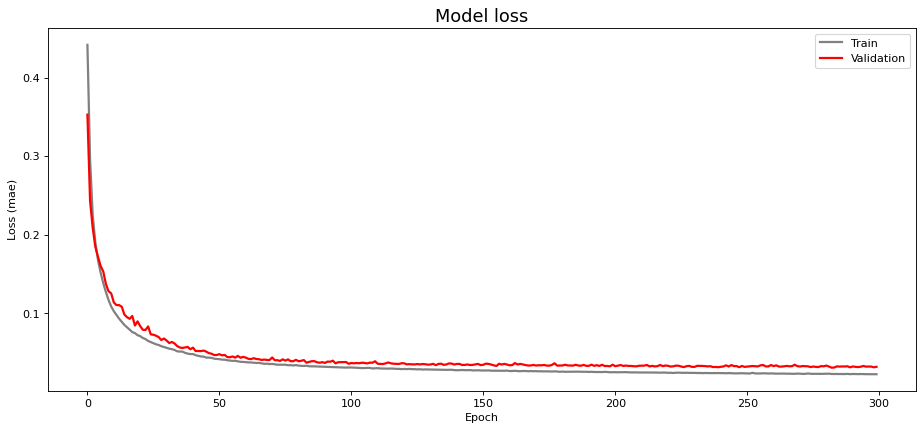


Target 1: Results of sklearn.metrics:
MAE: 3.47
MSE: 21.03
RMSE: 4.59
MAPE: 1.93
R-Squared: 0.98

Target 2: Results of sklearn.metrics:
MAE: 5.62
MSE: 57.43
RMSE: 7.58
MAPE: 3.04
R-Squared: 0.97

Target 3: Results of sklearn.metrics:
MAE: 9.51
MSE: 157.64
RMSE: 12.56
MAPE: 4.42
R-Squared: 0.95


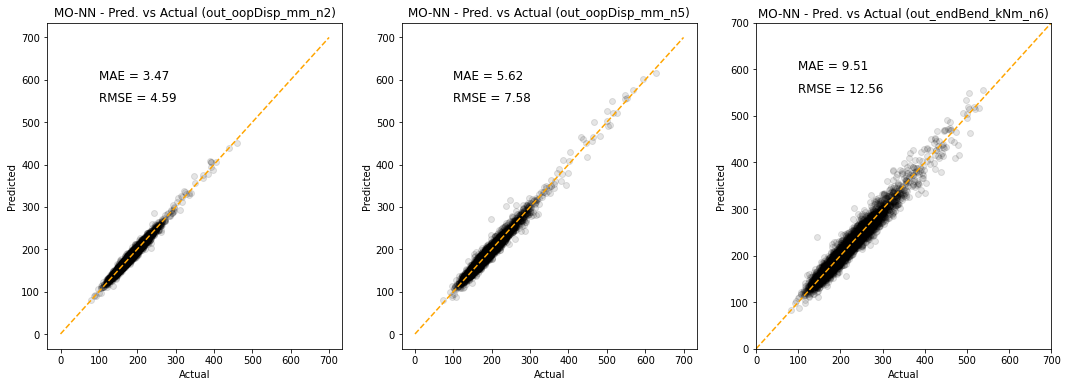

In [26]:
# Model suggested from Hyperband optimizer (bs=128 is default)
#out_104, model_104 = run_model(104, X_val, y_val, bs = len(train), epos = 7500, verb_out=1)
out_104, model_104 = run_model(104, X_val, y_val, verb_out=1)

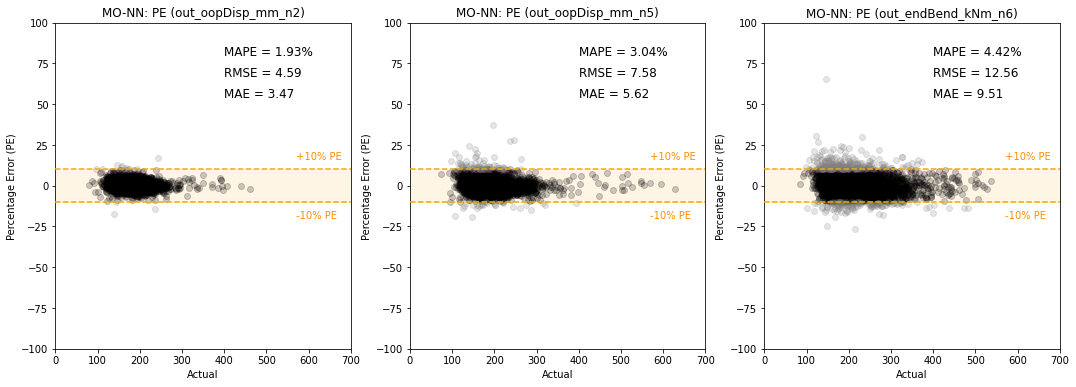

In [27]:
# Compute Errors Metrics.
gen_band_output(out_104)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 692)               8304      
                                                                 
 dense_22 (Dense)            (None, 3)                 2079      
                                                                 
Total params: 10,383
Trainable params: 10,383
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
317/317 [==============================] - 1s 4ms/step - loss: 0.4054 - val_loss: 0.3167
Epoch 2/300
317/317 [==============================] - 1s 3ms/step - loss: 0.2502 - val_loss: 0.2895
Epoch 3/300
317/317 [==============================] - 1s 3ms/step - loss: 0.2018 - val_loss: 0.2023
Epoch 4/300
317/317 [==============================] - 1s 3ms/step - loss: 0.1813 - val_loss: 0.2084
Epoch 5/300
317/317 [================

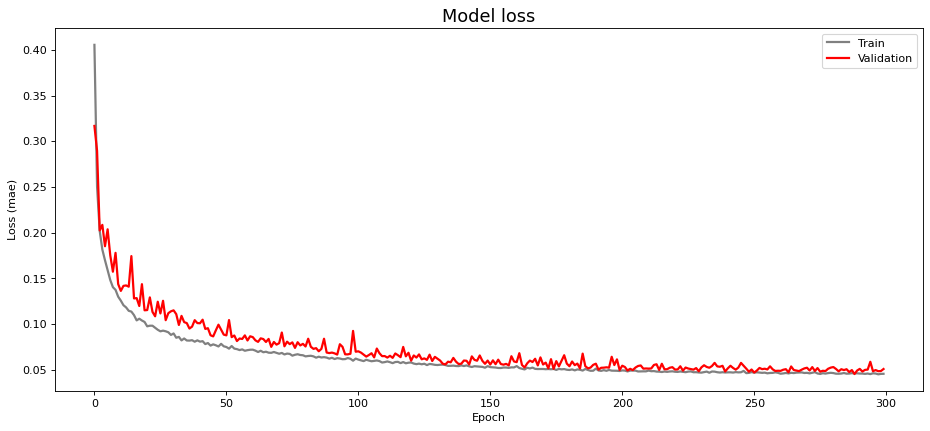


Target 1: Results of sklearn.metrics:
MAE: 4.52
MSE: 35.01
RMSE: 5.92
MAPE: 2.5
R-Squared: 0.96

Target 2: Results of sklearn.metrics:
MAE: 7.26
MSE: 92.09
RMSE: 9.6
MAPE: 3.93
R-Squared: 0.95

Target 3: Results of sklearn.metrics:
MAE: 11.79
MSE: 240.42
RMSE: 15.51
MAPE: 5.46
R-Squared: 0.93


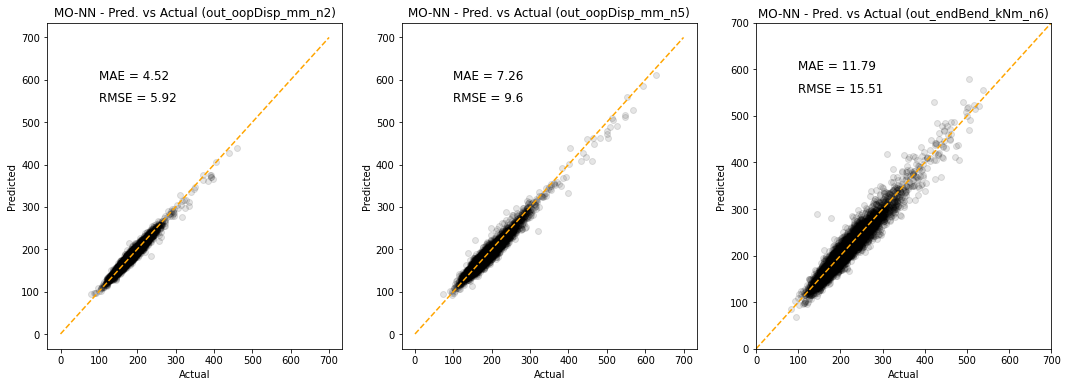

In [ ]:
# Model suggested from Hyperband optimizer (single hidden layer)
out_105, model_105 = run_model(105, X_val, y_val, verb_out=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 476)               5712      
                                                                 
 dense_24 (Dense)            (None, 188)               89676     
                                                                 
 dense_25 (Dense)            (None, 356)               67284     
                                                                 
 dense_26 (Dense)            (None, 3)                 1071      
                                                                 
Total params: 163,743
Trainable params: 163,743
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
317/317 [==============================] - 2s 4ms/step - loss: 0.3431 - val_loss: 0.2080
Epoch 2/300
317/317 [==============================] - 1s 4ms/step - loss:

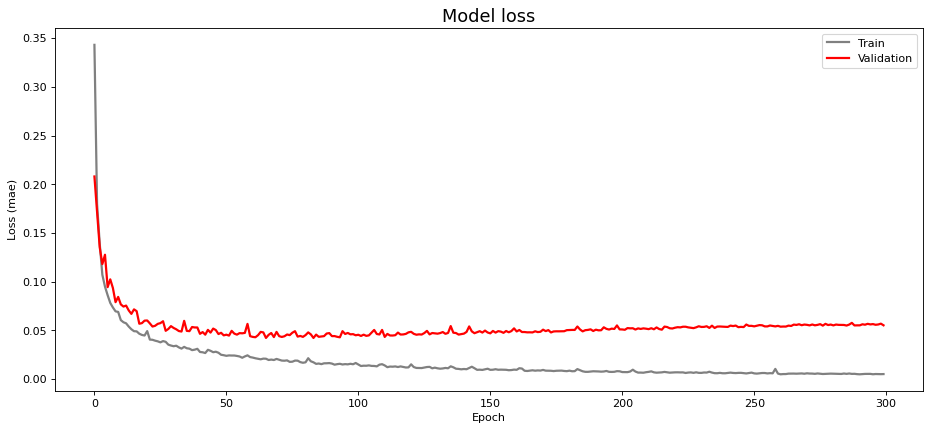


Target 1: Results of sklearn.metrics:
MAE: 4.75
MSE: 42.03
RMSE: 6.48
MAPE: 2.62
R-Squared: 0.96

Target 2: Results of sklearn.metrics:
MAE: 7.36
MSE: 109.41
RMSE: 10.46
MAPE: 3.89
R-Squared: 0.94

Target 3: Results of sklearn.metrics:
MAE: 11.47
MSE: 233.13
RMSE: 15.27
MAPE: 5.33
R-Squared: 0.93


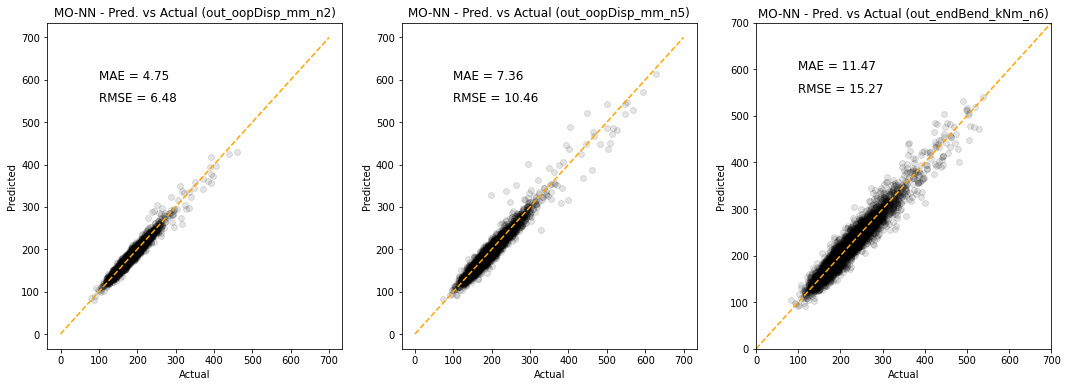

In [ ]:
# Model suggested from Hyperband optimizer (three hidden layers)
out_106, model_106 = run_model(106, X_val, y_val, verb_out=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 256)               3072      
                                                                 
 dense_28 (Dense)            (None, 512)               131584    
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 3)                 195       
                                                                 
Total params: 307,331
Trainable params: 307,331
Non-tr

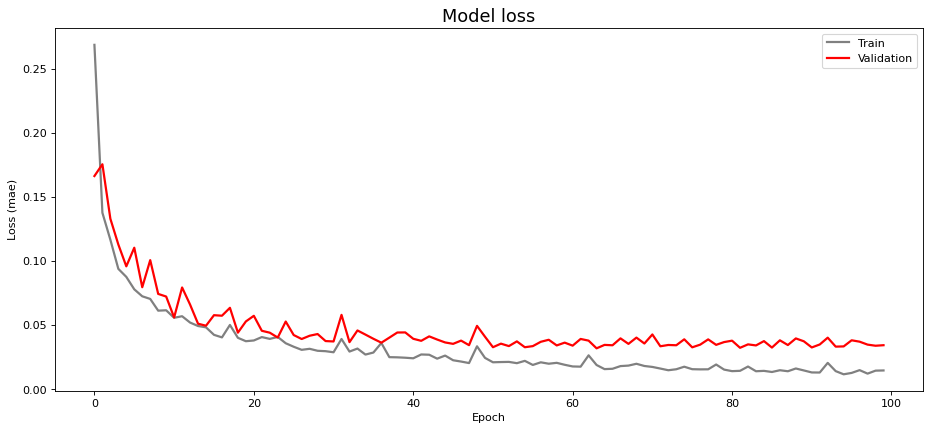


Target 1: Results of sklearn.metrics:
MAE: 3.75
MSE: 25.3
RMSE: 5.03
MAPE: 2.05
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 5.69
MSE: 61.5
RMSE: 7.84
MAPE: 3.02
R-Squared: 0.97

Target 3: Results of sklearn.metrics:
MAE: 9.31
MSE: 159.71
RMSE: 12.64
MAPE: 4.26
R-Squared: 0.95


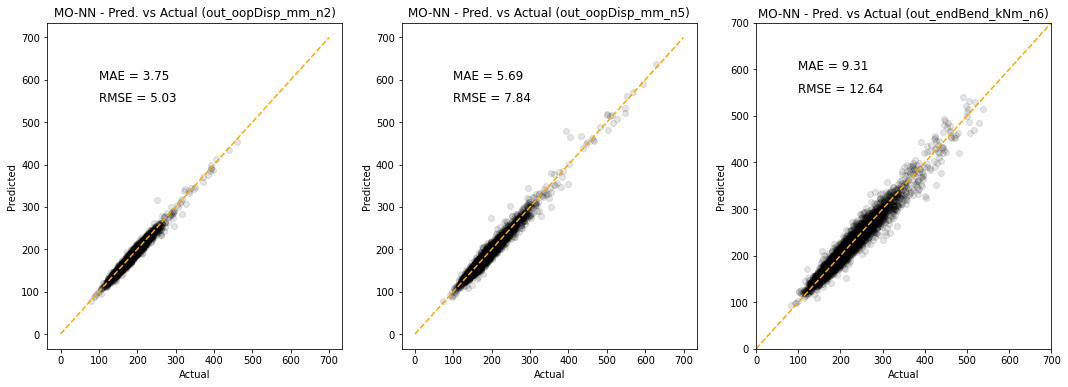

In [ ]:
# Model suggested from Hyperband optimizer (three hidden layers)
out_107, model_107 = run_model(107, X_val, y_val, epos=100, bs=100, verb_out=1)

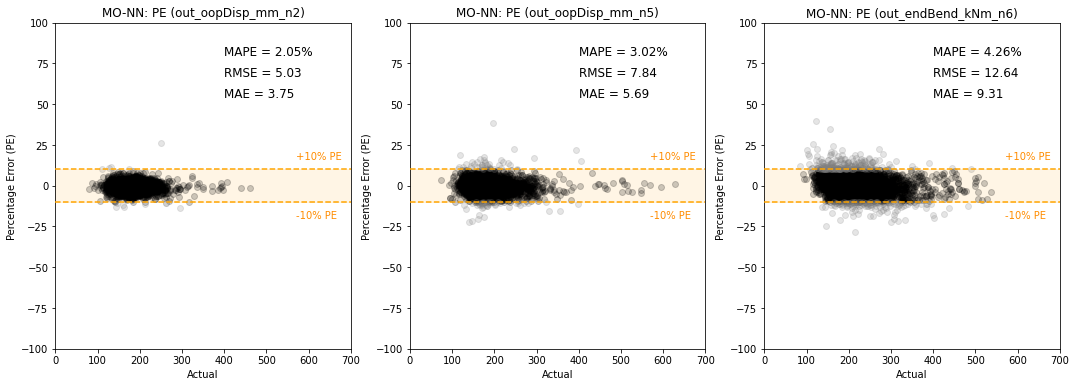

In [ ]:
gen_band_output(out_107)